Student Details

Name: **Abhijit Sinha**

ID: **18195067**

# Etivity5: Feature Selection 

This notebook builds on top of Lab 4 by introducing feature selection into the process of selecting the best classifier for a binary classification problem.

The feature selection method applied here is Recursive Feature Elimination (RFE) as demonstrated in the tutorial at https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/.

In this demonstration we use a modified version of the seeds data set (see https://archive.ics.uci.edu/ml/datasets/seeds), which is the same data set used in Lab 4.

## A. Preparation

### Import Python modules

In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing #needed for scaling attributes to the interval [0,1]

from sklearn import svm
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.feature_selection import RFE, SelectKBest, SelectPercentile, SelectFromModel # for feature selection
from sklearn.feature_selection import f_classif    #computes ANOVA f-value
from sklearn.feature_selection import mutual_info_classif    #computes the mutual information

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Using a global random seed for reproducible results when doing multiple runs
np.random.seed(0)

# Task 1
Repeat the experiment in Etivity5-Feature Selection.ipynb with winequality_red.csv and draw initial conclusions from the results you observe.

### Load and prepare the dataset for training and evaluation
Feel free to apply any other pre-processing technique at this point.

In [2]:
lab5_df = pd.read_csv("./winequality_red.csv")
lab5_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [3]:
lab5_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
lab5_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
lab5_df.shape

(1599, 12)

In [6]:
# target attribute
target_attribute_name = 'quality'
target = lab5_df[target_attribute_name]

# predictor attributes
predictors = lab5_df.drop(target_attribute_name, axis=1).values

## Target analysis 

In [7]:
# Check the target variables unique values
target.unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

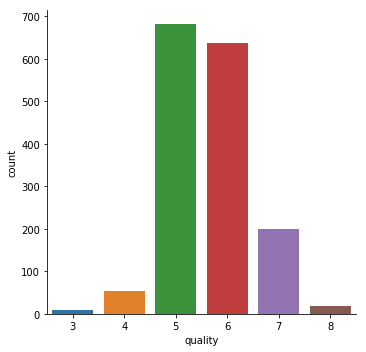

In [8]:
# Plot to show the number of observations in each target category
sns.catplot(x="quality", kind="count", data=lab5_df);

### Observations on Target Class
- Target is multi-class as it has a value in the range of 3 to 8. 
- The target class 5 and 6 have the most dominant sample counts with each having 600+ samples.

### Shuffle and do Stratified Split of the input data set into a training (80%) and test (20%) data sets.

In [9]:
# pepare independent stratified data sets for training and test of the final model
predictors_train, predictors_test, target_train, target_test = train_test_split(
    predictors, target, test_size=0.20, shuffle=True, stratify=target)

print(predictors_train.shape, predictors_test.shape, target_train.shape, target_test.shape)

(1279, 11) (320, 11) (1279,) (320,)


### Outlier analysis for dataset
This is needed to select the appropriate scaling method

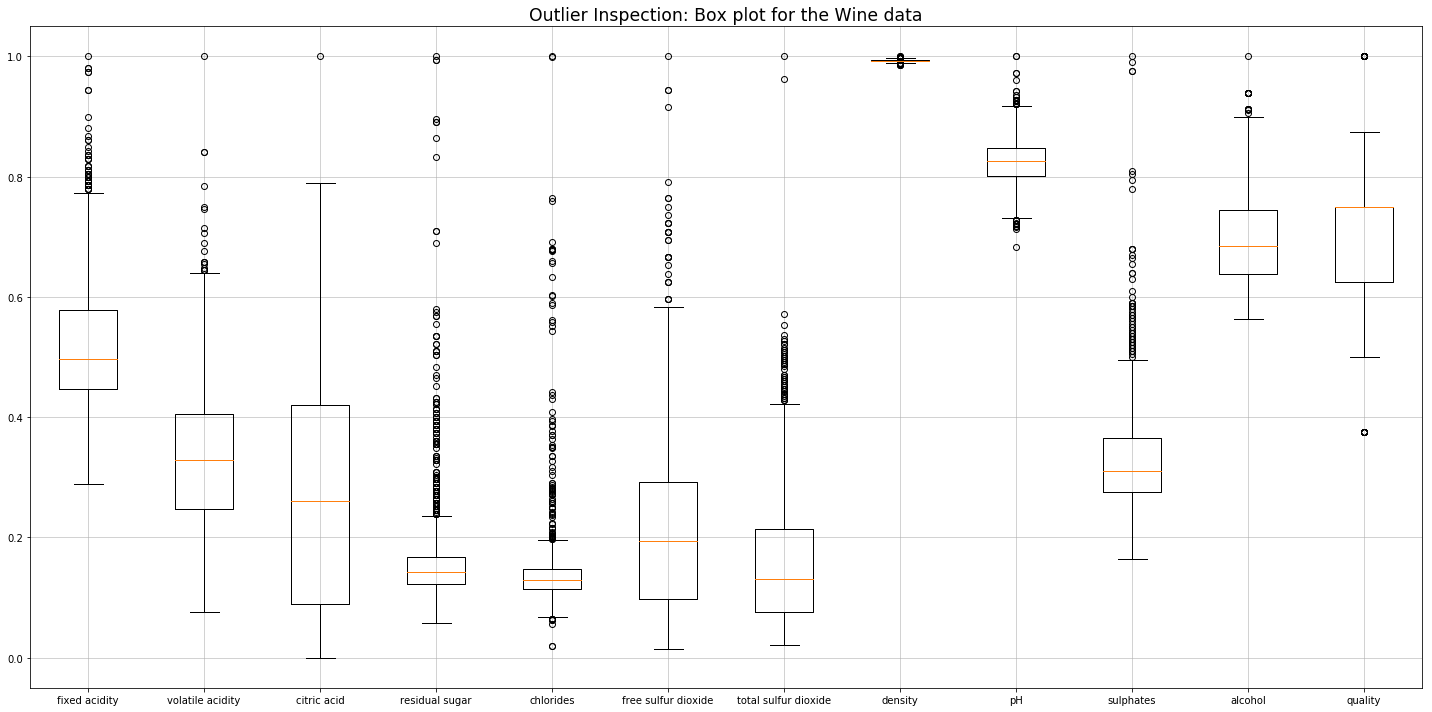

In [10]:
# Check if there are any outlier as it may affect the scaling algorithm
plt.figure(figsize=(20,10))
plt.boxplot([lab5_df[i]/lab5_df[i].max() for i in lab5_df.keys()], labels=lab5_df.keys())
plt.title('Outlier Inspection: Box plot for the Wine data',  fontsize='xx-large')
plt.grid(alpha=0.7)
plt.tight_layout()
plt.show()

### Observation on the Box Plots:
From the boxplot we can see that **there are some potential outliers in the dataset and this can affect the scaling outcome** and **Proper scaling technique needs to be used to counter the outliers**

### Scale the data to counter outliers

In [11]:
# Scale the data with appropriate scaler which can handle ouliers
scaler = preprocessing.RobustScaler()

# Fit the scaler on train data and transform it on train and test data 
# to avoid (data snooping) test data leaking into train data
scaler.fit(predictors_train)

# Scaling the train data set
predictors_train = scaler.transform(predictors_train)

# Scaling the test set using the transform defined by the train set.
predictors_test = scaler.transform(predictors_test)

Note:
I have tried a few scalers as mentioned below and selected Robust scaler as it can handle outliers better in dataset 
- power_transformer = preprocessing.PowerTransformer(method='yeo-johnson')
- quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal')
- robust_scaler = preprocessing.RobustScaler()
- min_max_scaler = preprocessing.MinMaxScaler()
- standard_scaler = preprocessing.StandardScaler()

## B. Feature Selection

#### 1. Apply RFE with SVM for selecting the best features

RFE is a wrapper method of feature selection

In [12]:
# create a base classifier used to evaluate a subset of attributes
estimatorSVM = svm.SVR(kernel="linear")
selectorSVM = RFE(estimatorSVM, 3)
selectorSVM = selectorSVM.fit(predictors_train, target_train)
# summarize the selection of the attributes
print(selectorSVM.support_)
print(selectorSVM.ranking_)

[False  True False False False False False False False  True  True]
[3 1 2 6 9 7 4 5 8 1 1]


In [13]:
num_cols = lab5_df.keys()
num_cols = np.delete(num_cols, np.where(num_cols == 'quality'), axis=0)

# Check which features are selected by SVM in RFE (Inspired by Aidan's work)
SVM_features = pd.DataFrame({'name':num_cols,
                             'rank':selectorSVM.ranking_,
                             'select':selectorSVM.support_}).sort_values(by='rank')
SVM_features

,name,rank,select
1,volatile acidity,1,True
9,sulphates,1,True
10,alcohol,1,True
2,citric acid,2,False
0,fixed acidity,3,False
6,total sulfur dioxide,4,False
7,density,5,False
3,residual sugar,6,False
5,free sulfur dioxide,7,False
8,pH,8,False


#### 2. Apply RFE with Logistic Regression for selecting the best features

In [14]:
# create a base classifier used to evaluate a subset of attributes
estimatorLR = LogisticRegression()
# create the RFE model and select 3 attributes
selectorLR = RFE(estimatorLR, 3)
selectorLR = selectorLR.fit(predictors_train, target_train)
# summarize the selection of the attributes
print(selectorLR.support_)
print(selectorLR.ranking_)

[False  True False False False False  True False False False  True]
[5 1 3 9 7 6 1 8 4 2 1]


In [15]:
# Check which features are selected by LGR
LR_features = pd.DataFrame({'name':num_cols,
                            'rank':selectorLR.ranking_,
                            'select':selectorLR.support_}).sort_values(by='rank')
LR_features

,name,rank,select
1,volatile acidity,1,True
6,total sulfur dioxide,1,True
10,alcohol,1,True
9,sulphates,2,False
2,citric acid,3,False
8,pH,4,False
0,fixed acidity,5,False
5,free sulfur dioxide,6,False
4,chlorides,7,False
7,density,8,False


## B. Evaluate on the Test Data Set

Apply the selectors to prepare training data sets only with the selected features

__Note:__ The same selectors are applied to the test data set. However, it is important that the test data set was not used by (it's invisible to) the selectors. 

In [16]:
predictors_train_SVMselected = selectorSVM.transform(predictors_train)
predictors_test_SVMselected = selectorSVM.transform(predictors_test)

In [17]:
predictors_train_LRselected = selectorLR.transform(predictors_train)
predictors_test_LRselected = selectorLR.transform(predictors_test)

### Train and evaluate SVM classifiers with both the selected features and all features 

Here we train three models:
* model1 - with the features selected by SVM
* model2 - with the features selected by Logistic Regression
* model3 - with all features (i.e. without feature selection)

In [18]:
classifier = svm.SVC()

In [19]:
model1 = classifier.fit(predictors_train_SVMselected, target_train)
model1.score(predictors_test_SVMselected, target_test)

0.621875

In [20]:
model2 = classifier.fit(predictors_train_LRselected, target_train)
model2.score(predictors_test_LRselected, target_test)

0.590625

In [21]:
model3 = classifier.fit(predictors_train, target_train)
model3.score(predictors_test, target_test)

0.65

## C. Initial conclusions from the results:

The results above, give evidence that **model3** is most accurate. However, when you execute this code again, it is very likely to get different results. I have also observed that the choice of scaling methods affect the scores.

# Task 2
- Repeat the experiment in Etivity5-Feature Selection.ipynb with winequality_red.csv
- Run the whole experiment in a loop with different training/test stratified splits. 
- Evaluate the three models for each iteration of the loop separately and boxplot the accuracies of the models for each iteration. 
- Compare the results of this experiment to the results of Task 1 in a markdown cell (max 150 words).

**[Rubric]:**
Loop implemented correctly with feature selection performed inside the loop. Results box-plotted and summarised correctly.


Reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

In [22]:
# Test Split Sizes
splits = np.arange(0.1, 0.55, 0.05)
print(splits)

[0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]


In [23]:
# Run the whole experiment in a loop with different training/validation stratified splits
model1_score = []
model2_score = []
model3_score = []

# Run the experiment multiple times on shuffled data to observe variance in results
# The test set will different in each run as we have shuffled the data in each loop
# The test size is split into 9 steps from 10% to 50% in inner loop
# Stratify will help in balancing the target class in train and test set.
for i in range(10):
    # loop to execute each test size 10 times
    for test_sz in splits:
        # loop to get different train-test split size 
        X_train, X_test, y_train, y_test = train_test_split(predictors, target, 
                                                         test_size=test_sz, shuffle=True, stratify=target)

        # Scale the train and test data
        scaler.fit(X_train)
        # Scaling the train data set
        X_train = scaler.transform(X_train)
        # Scaling the test set using the transform defined by the train set.
        X_test = scaler.transform(X_test)


        X_train_SVMselected = selectorSVM.transform(X_train)
        X_test_SVMselected  = selectorSVM.transform(X_test)

        X_train_LRselected = selectorLR.transform(X_train)
        X_test_LRselected  = selectorLR.transform(X_test)

        model1 = classifier.fit(X_train_SVMselected, y_train)
        model1_score.append(model1.score(X_test_SVMselected, y_test))

        model2 = classifier.fit(X_train_LRselected, y_train)
        model2_score.append(model2.score(X_test_LRselected, y_test))

        model3 = classifier.fit(X_train, y_train)
        model3_score.append(model3.score(X_test, y_test))


# Store the model scores in a pandas dataframe
accuracy_df = pd.DataFrame({'SVM Selected': model1_score,
                            'LR Selected' : model2_score,
                            'All Features': model3_score
                           })

accuracy_df.describe()

,SVM Selected,LR Selected,All Features
count,90.000000,90.000000,90.000000
mean,0.583370,0.581356,0.620408
std,0.020136,0.019796,0.022890
min,0.506250,0.528125,0.559375
25%,0.572734,0.568750,0.606250
50%,0.585208,0.583073,0.618750
75%,0.594643,0.596763,0.630859
max,0.631250,0.616667,0.679167


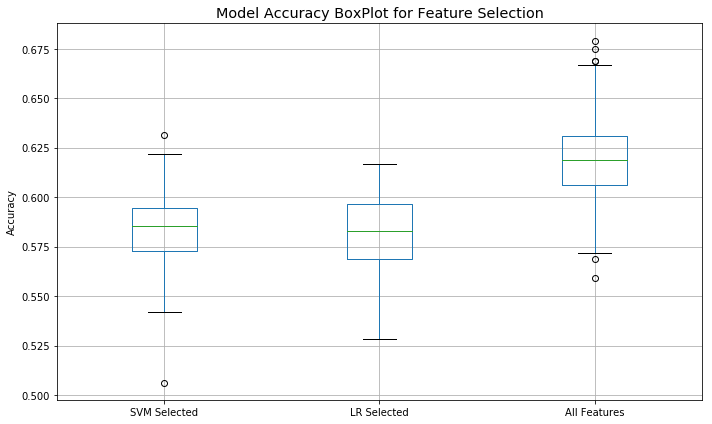

In [24]:
# Box plot the score for each model with various features for mutiple runs
accuracy_df.boxplot(figsize=(10,6))
plt.title("Model Accuracy BoxPlot for Feature Selection", fontsize='x-large')
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

### Observation:
- Model 3 which is SVM classifier with all features, seems to have a better overall accuracy score when we run the experiment multiple times.
- Its interesting to see that few results are also outliers

# Task 3
Build two pipelines for training classifiers for the dataset winequality_red.csv and summarise the results from training classifiers with the pipelines in a markdown cell (max 150 words). 

The two pipelines should include feature-selection methods, and the feature-selection method in pipeline 1 should be different from the feature-selection method in pipeline 2.

**[Rubric]:**
Two pipelines implemented without errors. The feature-selection method in pipeline 1 different from the feature-selection method in pipeline 2. Results summarised.

References: 
https://scikit-learn.org/stable/modules/feature_selection.html

### PCA Analysis
Just an analysis to see the feature variance based on the correlation in the data. I am not using this in the pipeline but wanted to demonstrate the dimensionality reduction method.

Singular values = 
 [90.93958394 73.19481754 43.99618936 35.23459271 34.82725422 27.37807513
 21.29548853 19.56606825 15.87073971 10.48058442  7.21690861]

Proportion of variance = 
 [0.4131438  0.26764305 0.09669977 0.06202029 0.06059458 0.03744563
 0.02265534 0.01912504 0.01258316 0.0054874  0.00260194]


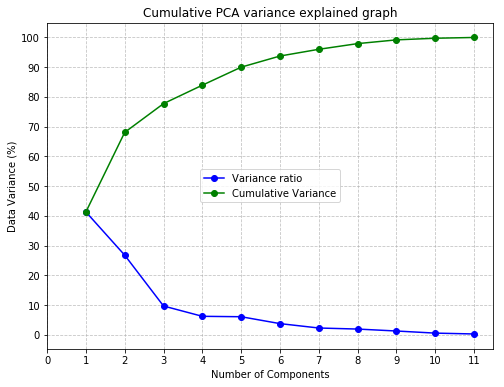

In [25]:
components = predictors_train.shape[1]

pca = PCA(n_components=components)
pca.fit_transform(predictors_train)

# Output PCA variance results
print("Singular values = \n",pca.singular_values_)  
print("\nProportion of variance = \n",pca.explained_variance_ratio_)  

# Plot the Cummulative PCA variance explained results to see how many features are really needed
plt.figure(figsize=(8,6))
pca_variance_ratio = pca.explained_variance_ratio_*100
plt.plot(range(1, components + 1), pca_variance_ratio, "bo-", 
         label="Variance ratio")
plt.plot(range(1, components + 1), np.cumsum(pca_variance_ratio), "go-", 
         label="Cumulative Variance")
plt.title("Cumulative PCA variance explained graph")

plt.xlabel("Number of Components")
plt.ylabel("Data Variance (%)")

plt.xticks(np.arange(0, components+1))
plt.yticks(np.arange(0, 100+10, 10))

plt.grid(alpha=0.75, linestyle='--')
plt.legend(loc='center')
plt.show()


The PCA analysis shows that if we use 9 principal components we can get almost 100% information form the data and with just 5 principal components we can get 90% of information.

I have also noted that there is a very strong effect of scaling methods on the data variance in PCA

### Pipeline
Pipeline can be used to chain multiple estimators into one to build a composite estimator.

In [26]:
# Function to create and evaluate the pipeline with provided estimaters and features

def evaluate_pipeline(estimator, X_train, X_test, y_train, y_test, title='Pipeline'):
    
    # Create pipeline
    pipeline = Pipeline(estimator)

    # Evaluate pipeline by cross-validation
    kfold = StratifiedKFold(n_splits=10, shuffle=True)
    results = cross_val_score(estimator=pipeline, X=X_train, y=y_train, cv=kfold, n_jobs=-1)

    # Fit the pipeline on train data
    pipeline.fit(X_train, y_train)

    # Make predictions on test data with pipeline
    y_pred = pipeline.predict(X_test)
    
    # Get pipeline accuracy on train and test data
    pipeline_score_train = pipeline.score(X_train, y_train)
    pipeline_score_test = pipeline.score(X_test, y_test)

    # Print results
    print("*************** {} Results.format(title) ***************")
    print("Mean CV score :{:.2f}(+/-{:.02f})".format(results.mean(), results.std()))
    print("Train Score   :{:.2f}".format(pipeline_score_train))
    print("Test Score    :{:.2f}".format(pipeline_score_test))
    
    return pipeline

In [27]:
# Checking the minimum value of train data. (based on scaling this is affected)
# This is done because we can't use chi2 scoring function 
# if we have negative data while using Univariate feature selection methods

predictors_train.min()

-3.350000000000002

## Pipeline 1
1. Feature Extraction using univariate feature selection method "SelectKBest" with "f_classif" scoring
2. Learn a SVM classification Model


In [28]:
estimators = []

# feature selection
estimators.append(('Univariate_select', SelectKBest(score_func=f_classif, k=3)))

# Select the classifier
estimators.append(('SVC', svm.SVC()))

# Create and Evaluate pipeline1
pipeline1 = evaluate_pipeline(estimators, predictors_train, predictors_test, 
                              target_train, target_test, title='Pipeline1')

*************** {} Results.format(title) ***************
Mean CV score :0.58(+/-0.02)
Train Score   :0.59
Test Score    :0.59


### Impact of Univariate_select__k value in the Pipeline 1 performance

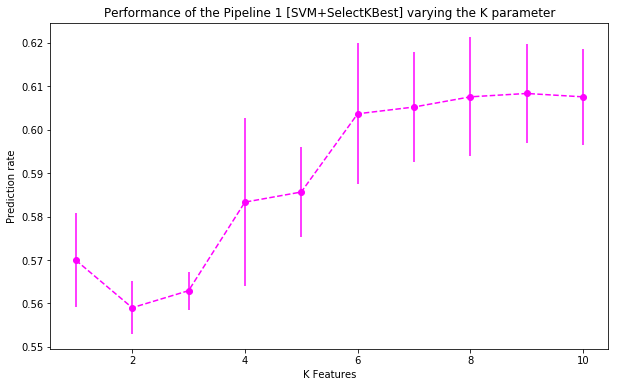

In [29]:
# The below code shows the effect of varying K in the pipleine1 with SelectKBest feature secltion 
# with SVM classifier

score_means = list()
score_stds = list()
k_features = range(1, predictors_test.shape[1])


for k in k_features:
    pipeline1.set_params(Univariate_select__k=k)
    # Compute cross-validation score 
    this_scores = cross_val_score(pipeline1, predictors_train, target_train, n_jobs=-1)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.figure(figsize=(10,6))
plt.errorbar(k_features, score_means, np.array(score_stds), color='magenta', marker='o', linestyle='--')
plt.title('Performance of the Pipeline 1 [SVM+SelectKBest] varying the K parameter')
plt.xlabel('K Features')
plt.ylabel('Prediction rate')
plt.show()

### Observations from Pipeline 1

In Pipeline 1, I have used SelectKBest Univariate Filter method for feature selection with variance analysis score function "f_classif" with 3 features.

The above picture shows the impact of feature K in the pipeline1 performance. If we use 4 features we get small improvement in accuracy score over 3 features, but we need to pay the price of the big variance too.

The train and test score are very close, around 59% with 3 features.

## Pipeline 2

1. Feature Extraction using SelectFromModel with "ExtraTreesClassifier"
2. Feature Extraction using SelectPercentile with "f_classif scoring" [Used only for analysis and not used in final pipeline]
3. Feature Union
4. Learn a SVM classification Model

In [30]:
# Create feature union with meta-transformer
features2 = []
features2.append(('SelectFromModel_ET', SelectFromModel(ExtraTreesClassifier(n_estimators=50))))

# The below was used as a feature union and can be enabled to vaidate the observation below
# In the final pipeline I have not used it but analyszed the effect of this approach below.
#features2.append(('anova', SelectPercentile(f_classif, percentile=50))) # taking percentile value of 50
feature_union2 = FeatureUnion(features2)

# Find the combined features from feature union:
pipe2_features = feature_union2.fit_transform(predictors_train, target_train)
print("Combined space has", pipe2_features.shape[1], "features\n")

# Select the classifier
estimators2 = []
estimators2.append(('feature_union', feature_union2))
estimators2.append(('SVC', svm.SVC()))

# Create and Evaluate pipeline2
pipeline2 = evaluate_pipeline(estimators2, predictors_train, predictors_test, 
                              target_train, target_test, title='Pipeline2')

Combined space has 4 features

*************** {} Results.format(title) ***************
Mean CV score :0.58(+/-0.04)
Train Score   :0.62
Test Score    :0.64


### Observations from Pipeline 2
Feature Union allows the results of multiple feature selection and extraction procedures to be combined into a larger dataset on which a model can be trained.

The observation on using various feature selection approach of Select from Model and Select percentile is mentioned in the table below:


| Feature Selection | num_features   | Mean CV score(%)  | Train Score(%) | Test Score(%) |
|-------------------|----------------|-------------------|----------------|---------------|
|SelectFromModel, ExtraTrees Classifier |4|60|62|64
|SelectPercentile, percentile=10|1|56|57|54
|SelectPercentile, percentile=30|3|58|59|59
|SelectPercentile, percentile=50|5|58|61|62
|Feature Union (ExtraTrees Classifier+ SelectPercentile, percentile=50) |9|59|62|63


So we can conclude that, SelectFromModel method with Extra Tree Classifier is selecting the feature more optimally rather than SelectPercentile Univariate method even with 50 percentile of features. The combined features approach here does not give better result as compared to SelectFromModel alone moreover, it increases the number of features with no gain in score.

References: 
- https://machinelearningmastery.com/automate-machine-learning-workflows-pipelines-python-scikit-learn/
- https://scikit-learn.org/stable/auto_examples/compose/plot_feature_union.html
- https://scikit-learn.org/0.18/auto_examples/svm/plot_svm_anova.html